# Temp_Obs_Pan01

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
import gsw

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46701,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46017,Total threads: 1
Dashboard: /proxy/43513/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:33019,


### Importing the data

In [3]:
# Model data
paths_model = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
lat_slice = slice(None,-39)

In [4]:
# Importing obs
shelf = xr.open_dataset('/g/data/g40/akm157/data/schmidtko/AASW_Temp_Salt.nc', chunks='auto')['CT'].sel(lat=lat_slice)
deep =  xr.open_dataset('/g/data/ik11/observations/woa23/woa23_decav_t00_04.nc', decode_times=False)['t_an'].sel(lat=lat_slice)

In [5]:
# Loading model data
def preprocess_model(ds):
    ds = ds[['thetao','so']].sel(yh=slice(None,-39))
    return ds
    
model = xr.open_mfdataset(paths_model, preprocess = preprocess_model, chunks = 'auto')

In [6]:
# Converting model to CT
# Calculating pressure
p_model = gsw.p_from_z(-model['z_l'], model['yh'])

# Calculating absolute salinity
SA_model = gsw.SA_from_SP(model['so'], p_model, model['xh'], model['yh'])

# Calculating conservative temperature
temp_model = gsw.CT_from_pt(SA_model,model['thetao'])

# Fix units
temp_model = xr.DataArray(temp_model, dims=model['thetao'].dims, coords=model['thetao'].coords)
temp_model.attrs['units'] = '°C'
temp_model.name = 'CT'

In [7]:
# Taking the average of the ten years after spin up
temp_model_ave = temp_model.sel(time=slice('2001-01-01','2010-12-31')).mean(dim='time')

In [8]:
temp_model_ave

<xarray.DataArray 'CT' (z_l: 75, yh: 821, xh: 3600)> Size: 2GB
dask.array<mean_agg-aggregate, shape=(75, 821, 3600), dtype=float64, chunksize=(22, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -39.18 -39.1 -39.03
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [9]:
# Extracting temperature at bottom
bottom_mask_temp_model = temp_model_ave.where(~np.isfinite(temp_model_ave.shift({'z_l': -1})))
bottom_mask_temp_model = ~np.isnan(bottom_mask_temp_model)

bottemp_model_map = temp_model_ave.where(bottom_mask_temp_model).sum(dim='z_l')

In [10]:
bottemp_model_map

<xarray.DataArray 'CT' (yh: 821, xh: 3600)> Size: 24MB
dask.array<sum-aggregate, shape=(821, 3600), dtype=float64, chunksize=(242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -39.18 -39.1 -39.03

In [11]:
temp_deep = deep.drop_vars('time')
temp_deep

<xarray.DataArray 't_an' (time: 1, depth: 102, lat: 204, lon: 1440)> Size: 120MB
[29963520 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 816B -89.88 -89.62 -89.38 ... -39.62 -39.38 -39.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Dimensions without coordinates: time
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [12]:
# Extracting temperature at bottom for WOA
bottom_mask_temp_deep = temp_deep.where(~np.isfinite(temp_deep.shift({'depth': -1})))
bottom_mask_temp_deep = ~np.isnan(bottom_mask_temp_deep)

bottemp_deep_map = temp_deep.where(bottom_mask_temp_deep).sum(dim='depth')

In [13]:
temp_shelf = shelf

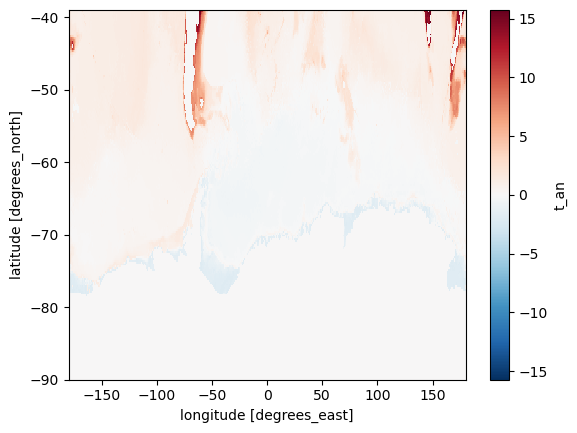

In [14]:
bottemp_deep_map.plot()

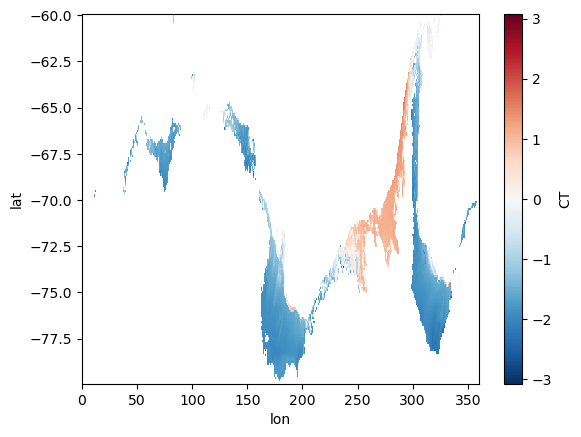

In [15]:
temp_shelf.plot()

In [16]:
def shift_lon_minus280_80(lon):
    """
    Shift longitudes to -280 -> 80 range.
    Works whether input is 0-360 or -180-180.
    """
    lon = lon % 360  # ensure 0-360
    lon_new = lon.copy()
    lon_new[lon > 80] -= 360  # shift values > 80 into negative range
    return lon_new

# Shelf
lon_shelf_new = shift_lon_minus280_80(temp_shelf.lon)
bottemp_shelf_map = temp_shelf.assign_coords(lon=lon_shelf_new).sortby("lon")

# Deep
lon_deep_new = shift_lon_minus280_80(bottemp_deep_map.lon)
bottemp_deep_map = bottemp_deep_map.assign_coords(lon=lon_deep_new).sortby("lon")


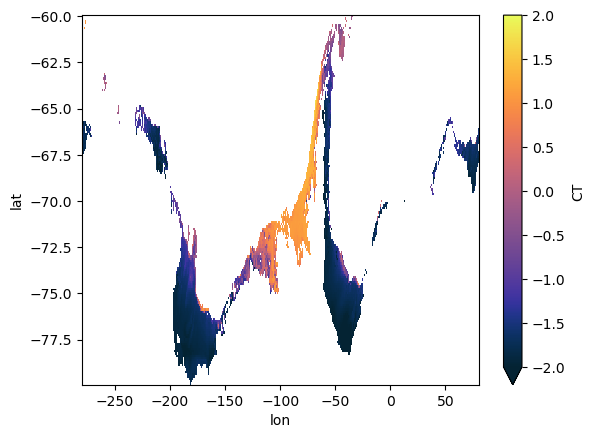

In [17]:
bottemp_shelf_map.plot(vmin=-2,vmax=2,cmap=cm.cm.thermal)

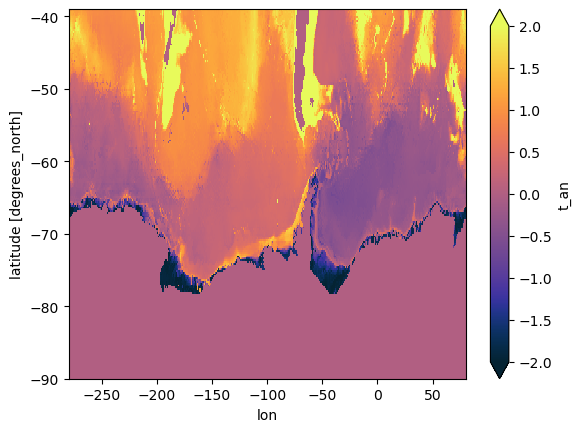

In [18]:
bottemp_deep_map.plot(vmin=-2,vmax=2,cmap=cm.cm.thermal)

In [19]:
#bottemp_model_map = bottemp_model_map.load()
#bottemp_model_map.to_netcdf('/g/data/x77/kc5856/thesis_model_validation/control_tob_last10yrave.nc')

In [20]:
bottemp_model_map = xr.open_dataset('/g/data/x77/kc5856/thesis_model_validation/control_tob_last10yrave.nc').to_array()

In [21]:
bottemp_model_map

<xarray.DataArray (variable: 1, yh: 821, xh: 3600)> Size: 24MB
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.36974457, 1.35828163, 1.33659668, ..., 1.3865559 ,
         1.37511201, 1.37262362],
        [1.35723506, 1.34587109, 1.32377397, ..., 1.37560512,
         1.36783082, 1.36376684],
        [1.35130147, 1.33793639, 1.30906744, ..., 1.36564105,
         1.35904379, 1.35398069]]])
Coordinates:
  * xh        (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh        (yh) float64 7kB -81.11 -81.07 -81.02 ... -39.18 -39.1 -39.03
  * variable  (variable) object 8B 'CT'

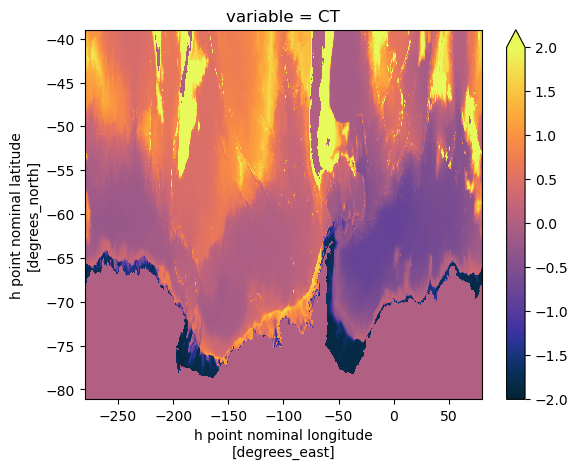

In [22]:
bottemp_model_map.plot(vmin=-2,vmax=2,cmap=cm.cm.thermal)

### Fix up the land masks

In [23]:
bottemp_deep_map_new = bottemp_deep_map.where(bottemp_deep_map != 0, np.nan)
bottemp_deep_map_new

<xarray.DataArray 't_an' (time: 1, lat: 204, lon: 1440)> Size: 1MB
array([[[    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        ...,
        [1.37809, 1.36239, 1.3503 , ..., 1.40789, 1.40289, 1.3833 ],
        [1.3833 , 1.36129, 1.34641, ..., 1.5539 , 1.40301, 1.3934 ],
        [1.36939, 1.35339, 1.33971, ..., 1.38429, 1.3968 , 1.3833 ]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 816B -89.88 -89.62 -89.38 ... -39.62 -39.38 -39.12
  * lon      (lon) float32 6kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
Dimensions without coordinates: time

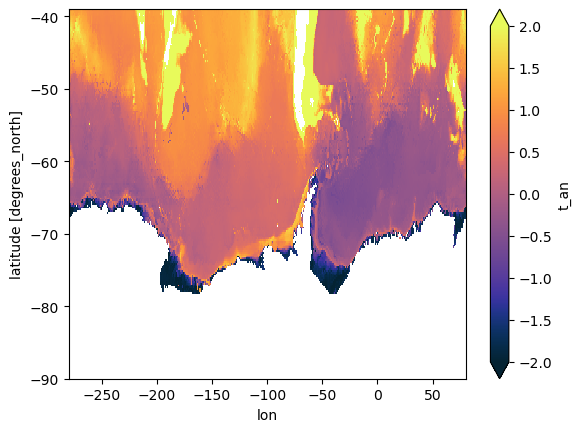

In [24]:
bottemp_deep_map_new.plot(vmin=-2,vmax=2,cmap=cm.cm.thermal)

In [25]:
bottemp_model_map_new = bottemp_model_map.where(bottemp_model_map != 0, np.nan)
bottemp_model_map_new

<xarray.DataArray (variable: 1, yh: 821, xh: 3600)> Size: 24MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [1.36974457, 1.35828163, 1.33659668, ..., 1.3865559 ,
         1.37511201, 1.37262362],
        [1.35723506, 1.34587109, 1.32377397, ..., 1.37560512,
         1.36783082, 1.36376684],
        [1.35130147, 1.33793639, 1.30906744, ..., 1.36564105,
         1.35904379, 1.35398069]]])
Coordinates:
  * xh        (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh        (yh) float64 7kB -81.11 -81.07 -81.02 ... -39.18 -39.1 -39.03
  * variable  (variable) object 8B 'CT'

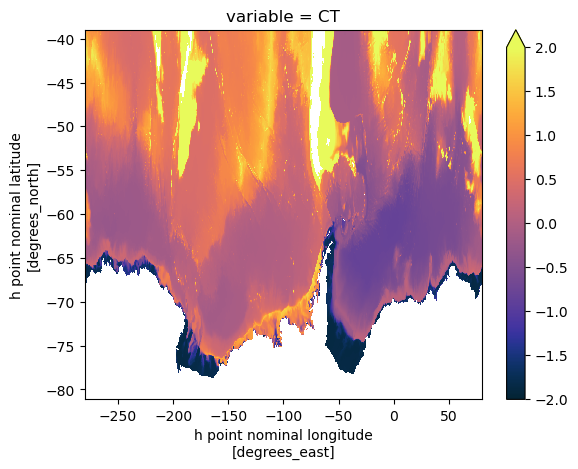

In [26]:
bottemp_model_map_new.plot(vmin=-2,vmax=2,cmap=cm.cm.thermal)

### Taking the anomalies

Shelf obs and model are both on 1/10th degree grids. (but not identical).  
WOA is on 1/4 degree.  
So we need to do some regridding.

In [27]:
import xesmf as xe

In [28]:
bottemp_model_map = bottemp_model_map.rename({'xh': 'lon', 'yh': 'lat'}) # comment out if already done this session

In [29]:
# Build regridder from model grid -> obs grid
# xESMF expects coords named 'lon' and 'lat' (or specify lon/lat dims explicitly).
regridder = xe.Regridder(bottemp_model_map, bottemp_deep_map_new, method='conservative')  # or 'bilinear'

# Regrid the high-res model onto the obs grid
model_on_obs = regridder(bottemp_model_map)

In [30]:
# compute anomaly
anomaly_deep = model_on_obs - bottemp_deep_map_new   # model minus obs (change sign if you prefer obs-model)

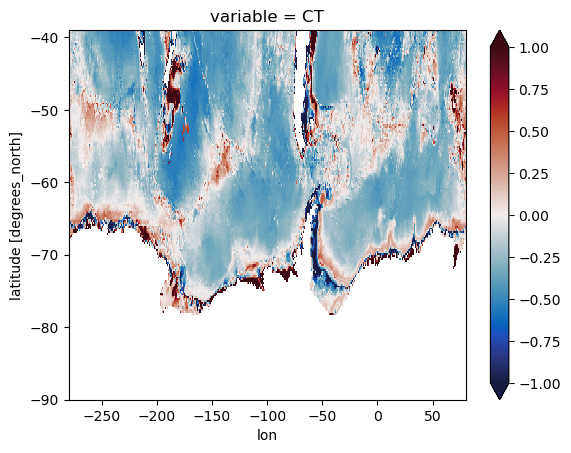

In [31]:
anomaly_deep.plot(vmin=-1,vmax=1,cmap=cm.cm.balance) # checking -1 to 1 range against Schmidt et al, 2025.

Doing the shelf anomaly:

In [32]:
# Check if grids are the same
print(bottemp_model_map.lon.equals(bottemp_shelf_map.lon))
print(bottemp_model_map.lat.equals(bottemp_shelf_map.lat))


False
False


In [33]:
## Model and shelf obs regridding
# Create regridder: model -> obs
regridder_shelf = xe.Regridder(bottemp_model_map, bottemp_shelf_map, method='conservative', periodic=True, reuse_weights=False)

# Regrid model onto obs grid
model_on_obs_shelf = regridder_shelf(bottemp_model_map)

In [34]:
shelf_mask = ~np.isnan(bottemp_shelf_map)  # True where obs exist (shelf)
anomaly_shelf = model_on_obs_shelf - bottemp_shelf_map   # model minus obs
anomaly_shelf = anomaly_shelf.where(shelf_mask)   # mask outside shelf

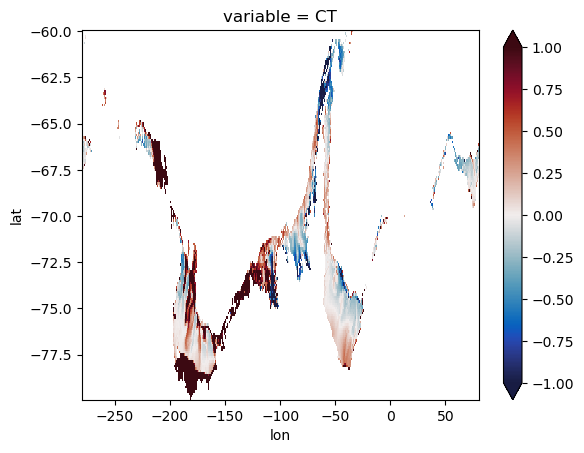

In [35]:
anomaly_shelf.plot(vmin=-1,vmax=1,cmap=cm.cm.balance)

In [36]:
# Save anomalies
anomaly_deep.to_netcdf('/g/data/x77/kc5856/thesis_model_validation/control_obs_tob_deep_anomaly.nc')
anomaly_shelf.to_netcdf('/g/data/x77/kc5856/thesis_model_validation/control_obs_tob_shelf_anomaly.nc')

#### Remove shelf from deep anomaly:

In [37]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

## Plotting

In [50]:
# Shelf contour
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

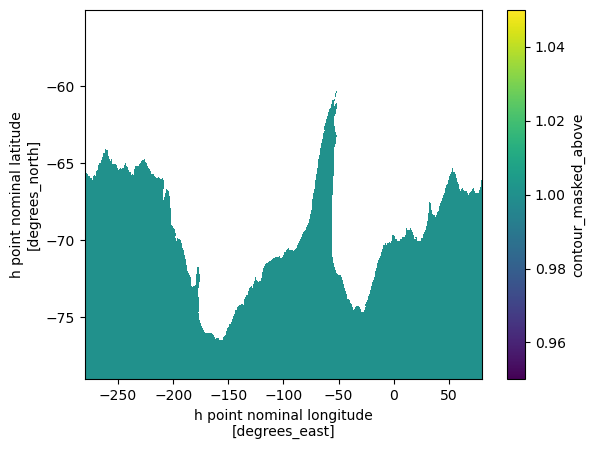

In [51]:
shelf_mask.where(shelf_mask == 1).plot()

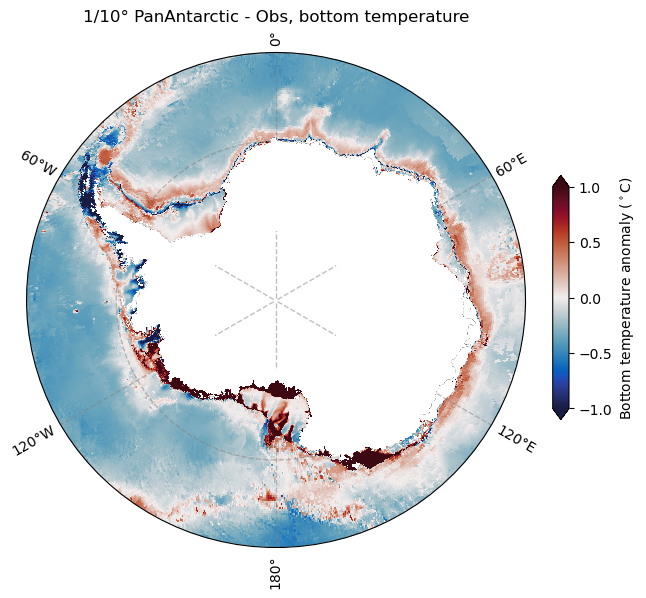

In [67]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=3,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask['xh'], shelf_mask['yh'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.1,transform = ccrs.PlateCarree())


#Plotting

anomaly_deep.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    add_colorbar=False,
    zorder= 1
)

# White shelf mask in between
shelf_mask.where(shelf_mask == 1).plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap="gray",  # black=0, white=1
    vmin=0, vmax=1,
)


anomaly_shelf.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom temperature anomaly ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    zorder= 4
)


# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

plt.title("1/10° PanAntarctic - Obs, bottom temperature");

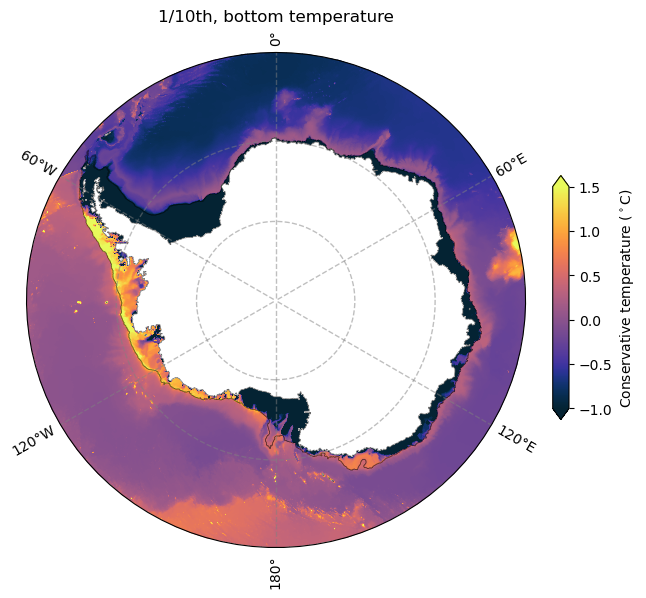

In [59]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.1,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
bottemp_model_map.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1.5,
    extend="both",
    cmap=cm.cm.thermal, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Conservative temperature ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("1/10th, bottom temperature");

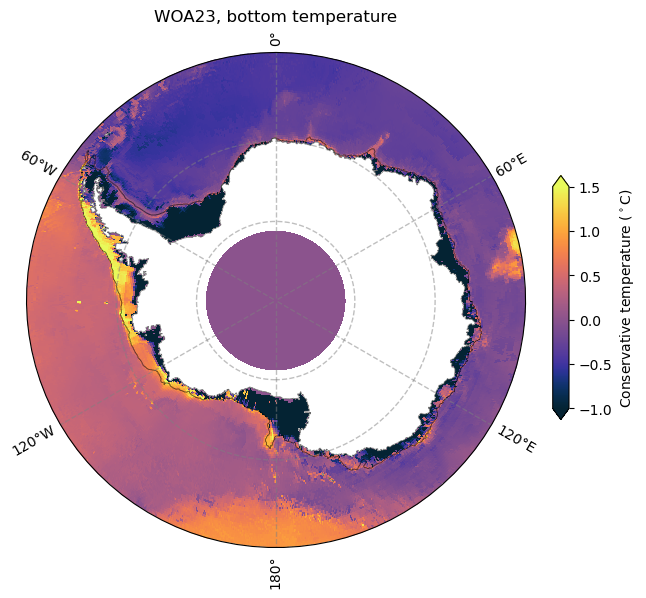

In [60]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.1,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
bottemp_deep_map.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1.5,
    extend="both",
    cmap=cm.cm.thermal, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Conservative temperature ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("WOA23, bottom temperature");

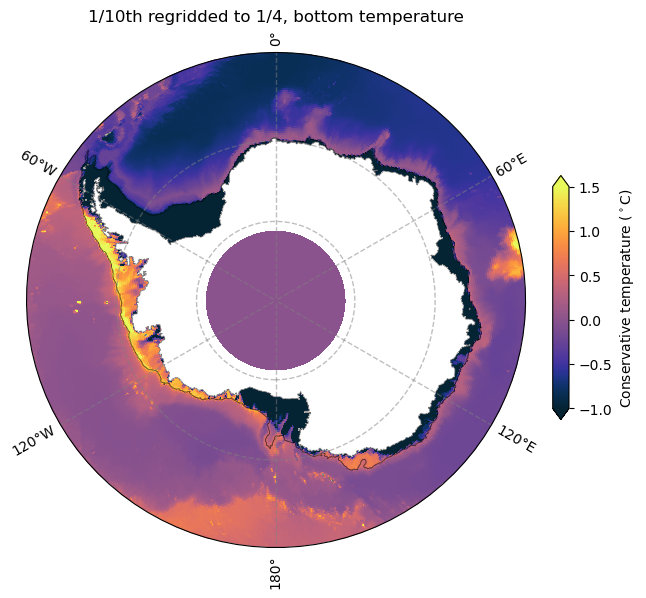

In [61]:
# With conservative temperature

projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.1,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
model_on_obs.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1.5,
    extend="both",
    cmap=cm.cm.thermal, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Conservative temperature ($^\circ$C)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("1/10th regridded to 1/4, bottom temperature");